In [35]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

In [36]:
df=pd.read_csv('./spam.csv',encoding="ISO-8859-1")
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [37]:
df=df[[df.columns[0], df.columns[1]]]
df=df.rename(columns={df.columns[0]: 'Categories', df.columns[1]: 'Massage'})
df

,Categories,Massage
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [38]:
df.Categories.value_counts()


ham     4825
spam     747
Name: Categories, dtype: int64

In [39]:
df.groupby('Categories').describe()

Massage                                                            \
             count unique                                                top   
Categories                                                                     
ham           4825   4516                             Sorry, I'll call later   
spam           747    653  Please call our customer service representativ...   

                 
           freq  
Categories       
ham          30  
spam          4

In [40]:
n=df[df['Categories'] == 'ham'].count()
n[0]

4825

calculate the percentage of spam and non-spam emails

In [41]:
ratio_email=df[df['Categories'] == 'ham'].count()/len(df)
ratio_spam=df[df['Categories'] == 'spam'].count()/len(df)
ratio_email, ratio_spam

(Categories    0.865937
 Massage       0.865937
 dtype: float64,
 Categories    0.134063
 Massage       0.134063
 dtype: float64)

This shows that we are facing with imbalanced data

In [43]:
X=df['Massage']
y=df['Categories']

convert X to vectors

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer()
X_tf=vectorizer.fit_transform(X)

Resampling

In [49]:
from imblearn.over_sampling import SMOTE
smote=SMOTE()
X_resample, y_resample=smote.fit_resample(X_tf,y)


In [54]:
X_resample.shape


(9650, 8672)

Convert vector to words and text to be prepared for using bert

In [57]:
reverse_transform = vectorizer.inverse_transform(X_resample)
resampled_texts = [' '.join(tokens) for tokens in reverse_transform]


In [58]:
resampled_texts

['wat amore got there cine buffet la world great bugis in only available crazy point jurong until go',
 'oni wif joking lar ok',
 '08452810075over18 apply rate txt std question receive 87121 text 2005 may 21st tkts final cup fa win to comp wkly entry free in',
 'then already hor early so say dun',
 'though here around lives usf goes he think don nah to',
 'rcv 50 send chgs xxx tb still for up you fun some like back word no and now week been it darling hey freemsg std to ok there',
 'patent aids treat they me with speak not is brother my even like to',
 'friends copy press callers all callertune set has vettam nurungu minnaminunginte oru melle request your per as for been to',
 'hours 12 valid kl341 code 09061701461 call claim reward prize 900 receivea selected have customer network valued winner as you been to only',
 '08002986030 on co camera mobiles colour latest the update entitled more or months 11 mobile had call your with for to free',
 'today enough cried ve tonight anymore stuf

In [81]:
import numpy as np
X_resample = pd.Series(resampled_texts)
X_resample.shape, y_resample.shape

((9650,), (9650,))

In [82]:
y_resample.value_counts()

ham     4825
spam    4825
Name: Categories, dtype: int64

In [83]:
X_resample

0       wat amore got there cine buffet la world great...
1                                   oni wif joking lar ok
2       08452810075over18 apply rate txt std question ...
3                       then already hor early so say dun
4       though here around lives usf goes he think don...
                              ...                        
9645    apply for your message http com wait why cente...
9646    in free entry wkly comp win fa 21st may 2005 t...
9647    free week now send 50 with this 20 16 reply ur...
9648    there you is today day www out find lucky log ...
9649    to win and be reply first answer order questio...
Length: 9650, dtype: object

In [84]:
type(y_resample), type(X_resample)

(pandas.core.series.Series, pandas.core.series.Series)

Convert categorical data to numbers

In [97]:
y_resample=y_resample.apply(lambda x: 1 if x=='spam' else 0)

split data to train and test

In [99]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test=train_test_split(X_resample,y_resample, test_size=0.2, shuffle=True, stratify=y_resample)


Now import bert and get embeding for few sentences

In [101]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

2023-06-03 20:24:53.175943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-06-03 20:24:53.176486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-06-03 20:24:53.176654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-06-03 20:24:53.177077: I tensorflow/core/

write a function to get a sentences and convert them to vectors

In [104]:
def get_sentences(sentence):
    pre_processing=bert_preprocess(sentence)
    embeding=bert_encoder(pre_processing)['pooled_output']
    return embeding


example

In [105]:
get_sentences([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435168 , -0.5132725 , -0.8884573 , ..., -0.7474888 ,
        -0.75314724,  0.91964483],
       [-0.87208354, -0.50543964, -0.9444667 , ..., -0.858475  ,
        -0.7174534 ,  0.8808297 ]], dtype=float32)>

get some embeding vectors for some words and compare their similarities

In [118]:
words_sample = get_sentences([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates",
    "james band"
]
)

In [124]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([words_sample[0]],[words_sample[1]])

array([[0.9911088]], dtype=float32)

In [125]:
cosine_similarity([words_sample[0]],[words_sample[6]])

array([[0.8800466]], dtype=float32)

In [126]:
cosine_similarity([words_sample[0]],[words_sample[3]])

array([[0.84703815]], dtype=float32)

In [127]:
cosine_similarity([words_sample[4]],[words_sample[5]])

array([[0.9164166]], dtype=float32)

Let's start modeling: 
There are twoways ofmodeling: sequential and functional. First start with sequentioa

In [142]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

2023-06-05 10:37:45.158866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]
2023-06-05 10:37:45.703065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_1' with dtype int32 and shape [?,128]
	 [[{{node Placeholder_1}}]]
2023-06-05 10:37:45.703209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_2' with dtype int32 and shape [?,128]
	 [[{{node

In [144]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [145]:
Metrics=[
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=Metrics)

In [146]:
model.fit(X_train,y_train, epochs=10)

Epoch 1/10
242/242 [==============================] - 1001s 4s/step - loss: 0.4117 - accuracy: 0.8646 - precision: 0.8571 - recall: 0.8751
Epoch 2/10
242/242 [==============================] - 977s 4s/step - loss: 0.2281 - accuracy: 0.9370 - precision: 0.9402 - recall: 0.9334
Epoch 3/10
242/242 [==============================] - 979s 4s/step - loss: 0.1801 - accuracy: 0.9475 - precision: 0.9509 - recall: 0.9438
Epoch 4/10
242/242 [==============================] - 956s 4s/step - loss: 0.1575 - accuracy: 0.9528 - precision: 0.9557 - recall: 0.9497
Epoch 5/10
242/242 [==============================] - 947s 4s/step - loss: 0.1398 - accuracy: 0.9602 - precision: 0.9640 - recall: 0.9562
Epoch 6/10
242/242 [==============================] - 964s 4s/step - loss: 0.1280 - accuracy: 0.9614 - precision: 0.9640 - recall: 0.9585
Epoch 7/10
242/242 [==============================] - 972s 4s/step - loss: 0.1174 - accuracy: 0.9654 - precision: 0.9687 - recall: 0.9619
Epoch 8/10
242/242 [=============

prediction

In [148]:
Predict=model.predict(X_test)

61/61 [==============================] - 267s 4s/step


In [149]:
Predict

array([[0.03258803],
       [0.97095114],
       [0.00230113],
       ...,
       [0.0090291 ],
       [0.8402564 ],
       [0.7888591 ]], dtype=float32)

Predict is two dimentional array. We use flatten to make it one dimentional array.

In [151]:
predict_flt=Predict.flatten()
predict_flt

array([0.03258803, 0.97095114, 0.00230113, ..., 0.0090291 , 0.8402564 ,
       0.7888591 ], dtype=float32)

Since Predict is the result of Sigmoid function, we use following function to convert them to 0 and 1

In [154]:
predict_flt=np.where(predict_flt>0.5, 1,0)
predict_flt

array([0, 1, 0, ..., 0, 1, 1])

In [160]:
from sklearn.metrics import confusion_matrix, classification_report
cm=confusion_matrix(predict_flt, y_test)
cm

array([[933,  20],
       [ 32, 945]])

Text(50.722222222222214, 0.5, 'Truth')

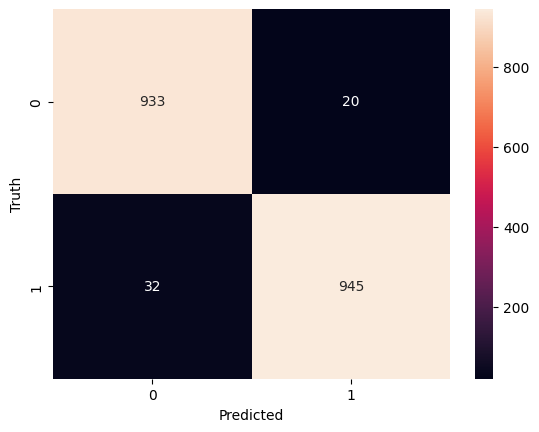

In [165]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [166]:
print(classification_report(y_test, predict_flt))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       965
           1       0.97      0.98      0.97       965

    accuracy                           0.97      1930
   macro avg       0.97      0.97      0.97      1930
weighted avg       0.97      0.97      0.97      1930



Some tests

In [167]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

2023-06-05 14:48:46.871049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]


1/1 [==============================] - 4s 4s/step


array([[0.7061082 ],
       [0.97779655],
       [0.7929735 ],
       [0.17988247],
       [0.03597472]], dtype=float32)